In [13]:
import numpy as np
import struct
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import cv2
import mtcnn.caffe_pb2 as pb
import math

In [14]:
class BBox:
    def __init__(self, x, y, r, b, score=0):
        self.x, self.y, self.r, self.b, self.score = x, y, r, b, score
        self.landmarks = []
        
    def __xor__(self, other):
        '''
        计算box和other的IoU
        '''
        cross = self & other
        union = self | other
        return cross / (union + 1e-6)
    
    def __or__(self, other):
        '''
        计算box和other的并集
        '''
        cross = self & other
        union = self.area + other.area - cross
        return union
        
    def __and__(self, other):
        '''
        计算box和other的交集
        '''
        xmax = min(self.r, other.r)
        ymax = min(self.b, other.b)
        xmin = max(self.x, other.x)
        ymin = max(self.y, other.y)
        cross_box = BBox(xmin, ymin, xmax, ymax)
        if cross_box.width <= 0 or cross_box.height <= 0:
            return 0
        
        return cross_box.area
    
    def locations(self):
        return self.x, self.y, self.r, self.b
    
    @property
    def center(self):
        return (self.x + self.r) / 2, (self.y + self.b) / 2
        
    @property
    def area(self):
        return self.width * self.height
    
    @property
    def width(self):
        return self.r - self.x + 1
    
    @property
    def height(self):
        return self.b - self.y + 1
    
    def __repr__(self):
        return f"{{{self.x:.2f}, {self.y:.2f}, {self.r:.2f}, {self.b:.2f}, {self.score:.2f}}}"

def nms(objs, iou_threshold):
    
    objs = sorted(objs, key=lambda x:x.score, reverse=True)
    removed_flags = [False] * len(objs)
    keeps = []
    
    for i in range(len(objs)):
        
        if removed_flags[i]:
            continue
        
        base_box = objs[i]
        keeps.append(base_box)
        for j in range(i+1, len(objs)):
            
            if removed_flags[j]:
                continue
            
            other_box = objs[j]
            iou = base_box ^ other_box
            
            if iou > iou_threshold:
                removed_flags[j] = True
    return keeps

In [15]:
class Module:
    def __init__(self, name):
        self.name = name
        self.train_mode = False
        
    def __call__(self, *args):
        return self.forward(*args)
    
    def train(self):
        self.train_mode = True
        for m in self.modules():
            m.train()
        
    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()
        
    def modules(self):
        ms = []
        for attr in self.__dict__:
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)
        return ms
    
    def params(self):
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]
            if isinstance(p, Parameter):
                ps.append(p)
            
        ms = self.modules()
        for m in ms:
            ps.extend(m.params())
        return ps
    
    def info(self, n):
        ms = self.modules()
        output = f"{self.name}\n"
        for m in ms:
            output += ('  '*(n+1)) + f"{m.info(n+1)}\n"
        return output[:-1]
    
    def __repr__(self):
        return self.info(0)
    
class Initializer:
    def __init__(self, name):
        self.name = name
        
    def __call__(self, *args):
        return self.apply(*args)
        
class GaussInitializer(Initializer):
    # where :math:`\mu` is the mean and :math:`\sigma` the standard
    # deviation. The square of the standard deviation, :math:`\sigma^2`,
    # is called the variance.
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def apply(self, value):
        value[...] = np.random.normal(self.mu, self.sigma, value.shape)
    
class Parameter:
    def __init__(self, value):
        self.value = value
        self.delta = np.zeros(value.shape)
        
    def zero_grad(self):
        self.delta[...] = 0
        
class Linear(Module):
    def __init__(self, input_feature, output_feature):
        super().__init__("Linear")
        self.input_feature = input_feature
        self.output_feature = output_feature
        self.weights = Parameter(np.zeros((input_feature, output_feature)))
        self.bias = Parameter(np.zeros((1, output_feature)))
        
        # 权重初始化 
        initer = GaussInitializer(0, np.sqrt(2 / input_feature))  # np.sqrt(2 / input_feature)
        initer.apply(self.weights.value)
        
    def forward(self, x):
        self.x_save = x.copy()
        return x @ self.weights.value + self.bias.value
    
    #AB = C  G
    #dB = A.T @ G
    #dA = G @ B.T
    def backward(self, G):
        self.weights.delta += self.x_save.T @ G
        self.bias.delta += np.sum(G, 0)  #值复制
        return G @ self.weights.value.T
    
class ReLU(Module):
    def __init__(self, inplace=True):
        super().__init__("ReLU")
        self.inplace = inplace
        
    # 亿点点
    def forward(self, x):
        self.negative_position = x < 0
        if not self.inplace:
            x = x.copy()
            
        x[self.negative_position] = 0
        return x
    
    def backward(self, G):
        if not self.inplace:
            G = G.copy()
            
        G[self.negative_position] = 0
        return G
    
class PReLU(Module):
    def __init__(self, num_feature, inplace=False):
        super().__init__("PReLU")
        self.inplace = inplace
        self.coeff = Parameter(np.zeros((num_feature)))
        
    def forward(self, x):
        if not self.inplace:
            x = x.copy()
            
        for channel in range(x.shape[1]):
            view = x[:, channel]
            negative_position = view < 0
            view[negative_position] *= self.coeff.value[channel]
        return x
    
class Softmax(Module):
    def __init__(self):
        super().__init__("Softmax")
        
    def forward(self, x):
        expx = np.exp(x)
        sumx = np.sum(expx, axis=1, keepdims=True)
        return expx / sumx

class SWish(Module):
    def __init__(self):
        super().__init__("SWish")
        
    def forward(self, x):
        self.x_save = x.copy()
        self.sx = sigmoid(x)
        return x * self.sx
    
    def backward(self, G):
        return G * (self.sx + self.x_save * self.sx * (1 - self.sx))
    
class Dropout(Module):
    def __init__(self, prob_keep=0.5, inplace=True):
        super().__init__("Dropout")
        self.prob_keep = prob_keep
        self.inplace = inplace
        
    def forward(self, x):
        if not self.train_mode:
            return x
        
        self.mask = np.random.binomial(size=x.shape, p=1 - self.prob_keep, n=1)
        if not self.inplace:
            x = x.copy()
            
        x[self.mask] = 0
        x *= 1 / self.prob_keep  # rescale
        return x
    
    def backward(self, G):
        if not self.inplace:
            G = G.copy()
        G[self.mask] = 0
        G *= 1 / self.prob_keep
        return G
    
class Conv2d(Module):
    def __init__(self, in_feature, out_feature, kernel_size, padding=0, stride=1):
        super().__init__("Conv2d")
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.kernel = Parameter(np.ones((out_feature, in_feature, kernel_size, kernel_size)))
        self.bias = Parameter(np.zeros((out_feature)))
        initer = GaussInitializer(0, np.sqrt(2 / in_feature))  # np.sqrt(2 / input_feature)
        initer.apply(self.kernel.value)
        
    def forward(self, x):
        self.in_shape = x.shape
        ib, ic, ih, iw = self.in_shape
        self.oh = (ih + self.padding * 2 - self.kernel_size) // self.stride + 1
        self.ow = (iw + self.padding * 2 - self.kernel_size) // self.stride + 1
        col_w = self.oh * self.ow
        col_h = self.kernel_size * self.kernel_size * self.in_feature
        self.column = np.zeros((ib, col_h, col_w))
        self.output = np.zeros((ib, self.out_feature, self.oh, self.ow))
        khalf = self.kernel_size // 2
        self.kcol = self.kernel.value.reshape(self.out_feature, -1)
        for b in range(ib):
            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                                column_y = ky * self.kernel_size + kx + c * self.kernel_size * self.kernel_size
                                column_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.column[b, column_y, column_x] = x[b, c, iy, ix]
            self.output[b] = (self.kcol @ self.column[b]).reshape(self.out_feature, self.oh, self.ow) + self.bias.value.reshape(self.out_feature, 1, 1)
        return self.output
    
    #AB = C  G
    #dB = A.T @ G
    #dA = G @ B.T
    def backward(self, G):
        
        ib, ic, ih, iw = self.in_shape
        for b in range(ib):
            self.kernel.delta += (G[b].reshape(self.out_feature, -1) @ self.column[b].T).reshape(self.kernel.value.shape)
    
        self.bias.delta += np.sum(G, axis=(0, 2, 3))
        self.Gout = np.zeros((self.in_shape))
        for b in range(ib):
            dcolumn = self.kcol.T @ G[b].reshape(self.out_feature, -1)
            
            # col2im
            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                                column_y = ky * self.kernel_size + kx + c * self.kernel_size * self.kernel_size
                                column_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.Gout[b, c, iy, ix] += dcolumn[column_y, column_x]
        return self.Gout
    
class Flatten(Module):
    def __init__(self):
        super().__init__("Flatten")
        
    def forward(self, x):
        self.in_shape = x.shape
        out = x.reshape(self.in_shape[0], -1)
        return out
    
    def backward(self, G):
        return G.reshape(self.in_shape)
    
class ModuleList(Module):
    def __init__(self, *args):
        super().__init__("ModuleList")
        self.ms = list(args)
        
    def modules(self):
        return self.ms
    
    def forward(self, x):
        for m in self.ms:
            x = m(x)
        return x
    
    def backward(self, G):
        for i in range(len(self.ms)-1, -1, -1):
            G = self.ms[i].backward(G)
        return G

class MaxPooling2d(Module):
    def __init__(self, kernel_size=2, stride=2):
        super().__init__("MaxPooling2d")
        self.kernel_size = kernel_size
        self.stride = stride
        
    def forward(self, x):
        ib, ic, ih, iw = x.shape
        oh, ow = int(np.ceil((ih - self.kernel_size) / self.stride) + 1), int(np.ceil((iw - self.kernel_size) / self.stride) + 1)
        output = np.zeros((ib, ic, oh, ow))
        for b in range(ib):
            for c in range(ic):
                for oy in range(oh):
                    for ox in range(ow):
                        ix = ox * self.stride
                        iy = oy * self.stride
                        output[b, c, oy, ox] = x[b, c, iy, ix]
                        
                        for kx in range(self.kernel_size):
                            for ky in range(self.kernel_size):
                                ix = ox * self.stride + kx
                                iy = oy * self.stride + ky
                                if ix < iw and iy < ih:
                                    output[b, c, oy, ox] = max(x[b, c, iy, ix], output[b, c, oy, ox])
        return output
    
# 
class BatchNormalization(Module):
    def __init__(self, in_feature, momentum=0.9, eps=1e-8):
        self.mu = 0
        self.var = 1
        self.momentum = momentum
        self.eps = eps
        self.in_feature = in_feature
        self.gamma = Parameter(np.ones(in_feature))
        self.beta = Parameter(np.zeros(in_feature))
        
    def forward(self, x):
        
        if not self.train_mode:
            y = (x - self.mu) / np.sqrt(self.var + self.eps)
            return y * self.gamma.value.reshape(1, -1, 1, 1) + self.beta.value.reshape(1, -1, 1, 1)
        
        self.b_mu = np.mean(x, axis=(0, 2, 3), keepdims=True)
        self.b_var = np.var(x, axis=(0, 2, 3), keepdims=True)
        self.y = (x - self.b_mu) / np.sqrt(self.b_var + self.eps)
        self.mu = self.b_mu * self.momentum + self.mu * (1 - self.momentum)
        
        n = x.size / x.shape[1]
        unbiased_var = self.b_var * n / (n - 1)
        self.var = unbiased_var * self.momentum + self.var * (1 - self.momentum)
        return self.y * self.gamma.value.reshape(1, -1, 1, 1) + self.beta.value.reshape(1, -1, 1, 1)
    
    def backward(self, G):
        self.gamma.delta = np.sum(G * self.y, axis=(0, 2, 3))
        self.beta.delta = np.sum(G, axis=(0, 2, 3))
        return G * self.gamma.value.reshape(1, -1, 1, 1) / np.sqrt(self.b_var + self.eps)

In [16]:
def fill_conv(layer_module, layer_weight):
    kernel_param = layer_module.kernel
    bias_param = layer_module.bias
    kernel_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(kernel_param.value.shape)
    bias_param.value[...] = np.array(layer_weight.blobs[1].data, dtype=np.float32).reshape(bias_param.value.shape)
    
def fill_prelu(layer_module, layer_weight):
    coeff_param = layer_module.coeff
    coeff_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(coeff_param.value.shape)

def fill_linear(layer_module, layer_weight):
    weights_param = layer_module.weights
    bias_param = layer_module.bias
    weights_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(*layer_weight.blobs[0].shape.dim).T
    bias_param.value[...] = np.array(layer_weight.blobs[1].data, dtype=np.float32).reshape(bias_param.value.shape)

In [17]:
class CaffeModelLoader:
    def load(self, file, *module_pairs):
        net = pb.NetParameter()
        with open(file, "rb") as f:
            net.ParseFromString(f.read())
            
        layer_map = {layer.name : layer for layer in net.layer}
        for layer_name, layer_module in module_pairs:
            if isinstance(layer_module, Conv2d):
                fill_conv(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, PReLU):
                fill_prelu(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, Linear):
                fill_linear(layer_module, layer_map[layer_name])
                

class Net(Module):
    def __init__(self, name, size):
        super().__init__(name)
        self.size = size
                
                
class PNet(Net, CaffeModelLoader):
    def __init__(self, file):
        super().__init__("PNet", 12)
        self.backbone = ModuleList(
            Conv2d(3, 10, 3),
            PReLU(10),
            MaxPooling2d(),
            Conv2d(10, 16, 3),
            PReLU(16),
            Conv2d(16, 32, 3),
            PReLU(32),
        )
        
        self.head_confidence = Conv2d(32, 2, 1)
        self.head_bbox = Conv2d(32, 4, 1)
        self.softmax = Softmax()
        
        self.load(file, 
            *list(zip(["conv1", "PReLU1", "pool1", "conv2", "PReLU2", "conv3", "PReLU3"], self.backbone.ms)),
            *list(zip(["conv4-1", "conv4-2"], [self.head_confidence, self.head_bbox]))
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x)
    
        
class RNet(Net, CaffeModelLoader):
    def __init__(self, file):
        super().__init__("RNet", 24)
        self.backbone = ModuleList(
            Conv2d(3, 28, 3),
            PReLU(28),
            MaxPooling2d(3, 2),
            Conv2d(28, 48, 3),
            PReLU(48),
            MaxPooling2d(3, 2),
            Conv2d(48, 64, 2),
            PReLU(64),
            Flatten(),
            Linear(576, 128),
            PReLU(128)
        )
        
        self.head_confidence = Linear(128, 2)
        self.head_bbox = Linear(128, 4)
        self.softmax = Softmax()
        
        self.load(file, 
            *list(zip(["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "flatten", "conv4", "prelu4"], self.backbone.ms)),
            *list(zip(["conv5-1", "conv5-2"], [self.head_confidence, self.head_bbox]))
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x)
    
    
class ONet(Net, CaffeModelLoader):
    def __init__(self, file):
        super().__init__("ONet", 48)
        self.backbone = ModuleList(
            Conv2d(3, 32, 3),
            PReLU(32),
            MaxPooling2d(3, 2),
            Conv2d(32, 64, 3),
            PReLU(64),
            MaxPooling2d(3, 2),
            Conv2d(64, 64, 3),
            PReLU(64),
            MaxPooling2d(2, 2),
            Conv2d(64, 128, 2),
            PReLU(128),
            Flatten(),
            Linear(1152, 256),
            PReLU(256)
        )
        
        self.head_confidence = Linear(256, 2)
        self.head_bbox = Linear(256, 4)
        self.head_landmark = Linear(256, 10)
        self.softmax = Softmax()
        
        self.load(file, 
            *list(zip(["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "pool3", "conv4", "prelu4", "flatten", "conv5", "prelu5"], self.backbone.ms)),
            *list(zip(["conv6-1", "conv6-2", "conv6-3"], [self.head_confidence, self.head_bbox, self.head_landmark]))
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x), self.head_landmark(x)

In [18]:
class MTCNN(Module):
    def __init__(self):
        self.pnet = PNet("mtcnn/det1.caffemodel")
        self.rnet = RNet("mtcnn/det2.caffemodel")
        self.onet = ONet("mtcnn/det3.caffemodel")
        
        
    def pyrdown(self, image, min_face=12, max_face=0, factor=0.709):
        
        image_height, image_width = image.shape[:2]
        m = 12 / min_face  # 12   m = 1,    24    m  0.5
        minl = min(image_width, image_height)
        scale = 1.0
        scales_select = []
        # 如果原始1.0比例的时候，是一个像素单位，那么当比例达到一定值的小的时候，像素值代表更大的图，此时这个代表如果超过最大人脸则不需要
        min_scale = 12 / max_face if max_face != 0 else 0
        
        minl *= m  # 
        while minl >= 12.0 and m * scale >= min_scale:
            scales_select.append(m * scale)
            scale *= factor
            minl *= factor
        
        if len(scales_select) == 0:
            return []
        
        pyrs = []
        for scale in scales_select:
            pyrs.append([cv2.resize(image, (0, 0), fx=scale, fy=scale), scale])
        return pyrs
        
    # Net 模型
    # imagepairs，是图像对，是图像金字塔的图像对[[图像，scale], [图像，scale]]
    # confidence_threshold，正类概率的阈值
    # nms_threshold，非极大值抑制的阈值
    def proposal(self, net, imagepairs, conf_threshold=0.6, nms_threshold=0.5):
        
        # 网络有一个pooling层，stride=2
        stride = 2
        
        # cellsize，就是窗口的大小，就是感受野
        cellsize = net.size
        objs = []
        
        # 循环每一个尺度
        for image, scale in imagepairs:
            
            # 是因为matlab训练的模型，具有列排列问题，所以得这么做，如果是自己训练的，通常没这么回事
            # 图像转置, h, w, c  ->   w, h, c
            # 处理成c, w, h
            input_image = image.transpose(2, 1, 0)[None]  # 图像转置，转换到张量
            
            # 图像放到模型中进行推理
            conf, reg = net(input_image)  # PNet的推理
            
            # 获取正类概率大于阈值的结果，0channel是指负例，1channel指正例
            # conf 0个图像， 1通道就是正例的概率
            # 通过where函数，获取正例概率大于指定阈值的条目
            ys, xs = np.where(conf[0, 1] > conf_threshold)
            
            # xs和ys是坐标的数组
            for y, x in zip(ys, xs):
                
                # 获取每一个xy对应的得分
                score  = conf[0, 1, y, x]

                # 开始计算cell对应原图上的位置
                # 计算的是划窗的窗口位置
                bx = (y * stride + 1) / scale        # 由于图像是转置的，所以x和ycell坐标对调，但是reg里面的x、y不对调
                by = (x * stride + 1) / scale
                br = (y * stride + cellsize) / scale
                bb = (x * stride + cellsize) / scale

                # reg: 1x4x70x70
                regx = reg[0, 0, y, x]
                regy = reg[0, 1, y, x]
                regr = reg[0, 2, y, x]
                regb = reg[0, 3, y, x]

                bw = br - bx + 1  # 12
                bh = bb - by + 1  # 12 
                bx = bx + regx * bw
                by = by + regy * bh
                br = br + regr * bw
                bb = bb + regb * bh
                objs.append(BBox(bx, by, br, bb, score))
        objs = nms(objs, nms_threshold)
        return objs
    
    
    def crop_resize_to2(self, src, roi, dst):
        ih, iw = src.shape[:2]
        dh, dw = dst.shape[:2]
        x, y, r, b = roi
        roi_size = r - x + 1
        xdis = -x if x < 0 else 0
        ydis = -y if y < 0 else 0
        rdis = r + 1 - iw if r >= iw else 0
        bdis = b + 1 - ih if b >= ih else 0
        dx, dy, dr, db = [item / roi_size * dw for item in [xdis, ydis, rdis, bdis]]
        crop_src_image_x, crop_src_image_y, crop_src_image_r, crop_src_image_b = x+xdis, y+ydis, r+rdis, b+bdis
        crop_dst_image_x = int(max(0, min(dx + 0.5, dw-1)))
        crop_dst_image_y = int(max(0, min(dy + 0.5, dw-1)))
        crop_dst_image_r = int(max(0, min(dw - dr + 0.5, dw-1)))
        crop_dst_image_b = int(max(0, min(dh - db + 0.5, dw-1)))
        crop_src_image = src[crop_src_image_y:crop_src_image_b+1, crop_src_image_x:crop_src_image_r+1]
        crop_dst_image = dst[crop_dst_image_y:crop_dst_image_b+1, crop_dst_image_x:crop_dst_image_r+1]
        crop_dst_height, crop_dst_width = crop_dst_image.shape[:2]
        cv2.resize(crop_src_image, (crop_dst_width, crop_dst_height), dst=crop_dst_image)
    
    
    # 将原始图复制到目标图，此时保留原始图的目标中心在目标图的中心上
    def crop_resize_to(self, src, roi, dst):
        dh, dw = dst.shape[:2]
        sh, sw = src.shape[:2]
        x, y, r, b = roi
        rcx, rcy = (x + r) / 2, (y + b) / 2
        rh, rw = b - y + 1, r - x + 1
        sx = dw / rw
        sy = dh / rh
        s = min(sx, sy)
        uh, uw = s * rh, s * rw
        ux = (dw - uw) / 2
        uy = (dh - uh) / 2
        ur = (dw + uw) / 2
        ub = (dh + uh) / 2
        lx = int(max(0, min(x+0.5, sw - 1)))   # 限制范围，必须得大于等于0，得小于等于sw-1
        ly = int(max(0, min(y+0.5, sh - 1)))
        lr = int(max(0, min(r+0.5, sw - 1)))
        lb = int(max(0, min(b+0.5, sh - 1)))
        ux = int(max(0, min(ux - (x - lx) * s + 0.5, dw - 1)))
        uy = int(max(0, min(uy - (y - ly) * s + 0.5, dh - 1)))
        ur = int(max(0, min(ur - (r - lr) * s + 0.5, dw - 1)))
        ub = int(max(0, min(ub - (b - lb) * s + 0.5, dh - 1)))
        cv2.resize(src[ly:lb+1, lx:lr+1], (ur-ux+1, ub-uy+1), dst=dst[uy:ub+1, ux:ur+1])
        return s
    
    def refine(self, net, objs, image, has_landmark, conf_threshold=0.7, nms_threshold=0.7):
        
        if len(objs) == 0:
            return []
        
        batch_crop_image = []
        
        # 对objs的每一个框进行抠图，并存储到batch_crop_image中
        # 抠图方式，是采用居中的方式进行的
        for obj in objs:
            x, y, r, b = obj.locations()
            maxl = max(obj.width, obj.height)
            cx, cy = obj.center
            x = cx - maxl * 0.5
            y = cy - maxl * 0.5
            r = cx + maxl * 0.5
            b = cy + maxl * 0.5
            crop_resized = np.zeros((net.size, net.size, 3), dtype=np.float32)
            self.crop_resize_to(image, (x, y, r, b), crop_resized)
            batch_crop_image.append(crop_resized.transpose(2, 1, 0)[None])
            
        batch_image = np.vstack(batch_crop_image)
        predict = net(batch_image)
        conf_all, reg_all = predict[:2]
        cell_size = net.size
        if has_landmark:
            landmark = predict[2]
        
        keep_objs = []
        for batch_index, obj in enumerate(objs):
            conf, reg = conf_all[batch_index, 1], reg_all[batch_index]
            if conf > conf_threshold:
                regx, regy, regr, regb = reg
                maxl = max(obj.width, obj.height)
                cx, cy = obj.center
                x = cx - (0.5 - regx) * maxl
                y = cy - (0.5 - regy) * maxl
                r = cx + (0.5 + regr) * maxl
                b = cy + (0.5 + regb) * maxl
                new_obj = BBox(x, y, r, b, conf)
                
                if has_landmark:
                    keys = landmark[batch_index]
                    new_obj.landmarks = []
                    for x, y in zip(keys[:5], keys[5:]):
                        x = cx + (x - 0.5) * maxl
                        y = cy + (y - 0.5) * maxl
                        new_obj.landmarks.append((x, y))
                keep_objs.append(new_obj)
                
        return nms(keep_objs, nms_threshold)
        
        
    # 目标检测，要求输入的是bgr的图像，3通道
    def detect(self, image, min_size=30, max_face=0):
        
        # 因为这个模型是matlab训练的，图像加载采用的是RGB格式
        self.input_image = image[..., ::-1] # BGR2RGB
        
        # 对图像进行归一化
        self.input_image = ((self.input_image - 127.5) / 128.0).astype(np.float32)
        
        # 图像金字塔，产生多尺度的图像，用以PNet进行检测
        self.pyrs = self.pyrdown(self.input_image, min_size, max_face)
        
        # 推荐框，proposal，recall要比较高的场景，错误会很高，但是召回率高就行
        self.objs = self.proposal(self.pnet, self.pyrs, nms_threshold=0.6)
        
        #print("Proposal bbox size: ", len(self.objs))
        self.robjs = self.refine(self.rnet, self.objs, self.input_image, False, nms_threshold=0.6)
        self.oobjs = self.refine(self.onet, self.robjs, self.input_image, True, nms_threshold=0.5)
        return self.oobjs

In [19]:
%%time
mtcnn = MTCNN()

CPU times: user 117 ms, sys: 21.2 ms, total: 138 ms
Wall time: 160 ms


CPU times: user 9.99 s, sys: 1.19 s, total: 11.2 s
Wall time: 4.75 s


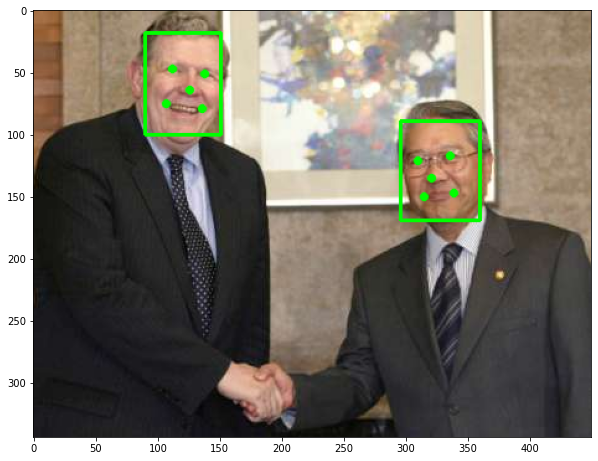

In [20]:
%%time
image = cv2.imread("test1.jpg")
objs = mtcnn.detect(image, 50, 80)
for obj in mtcnn.oobjs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(image, (bx, by), (br, bb), (0, 255, 0), 2)
    
    for x, y in obj.landmarks:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1, 16)
    
plt.figure(figsize=(10, 10))
plt.imshow(image[...,::-1])

CPU times: user 1min 1s, sys: 5.96 s, total: 1min 7s
Wall time: 30.7 s


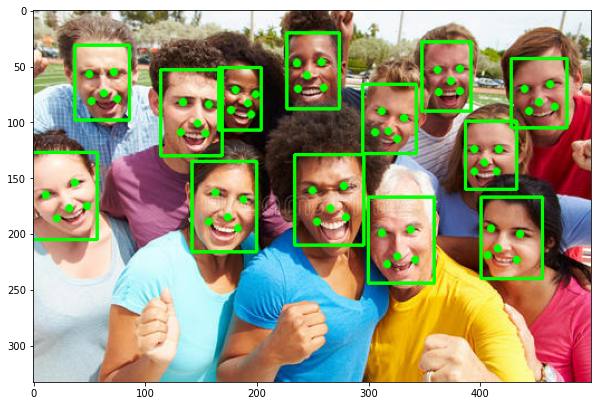

In [21]:
%%time
image = cv2.imread("rq.jpg")
objs = mtcnn.detect(image, 30, 50)
for obj in mtcnn.oobjs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(image, (bx, by), (br, bb), (0, 255, 0), 2)
    
    for x, y in obj.landmarks:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1, 16)
    
plt.figure(figsize=(10, 10))
plt.imshow(image[...,::-1])

CPU times: user 9.73 s, sys: 1.06 s, total: 10.8 s
Wall time: 4.48 s


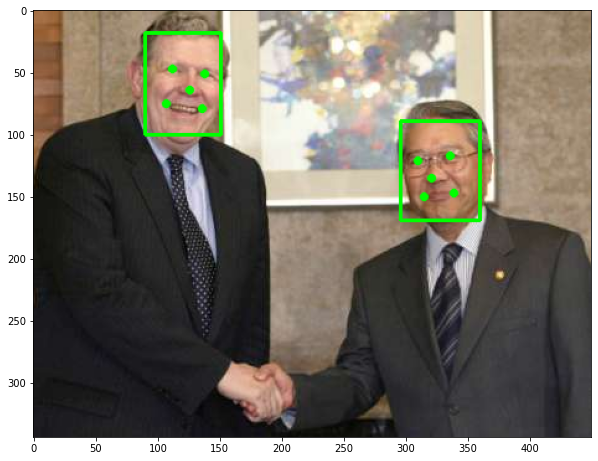

In [22]:
%%time
image = cv2.imread("test1.jpg")
objs = mtcnn.detect(image, 50, 80)
for obj in mtcnn.oobjs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(image, (bx, by), (br, bb), (0, 255, 0), 2)
    
    for x, y in obj.landmarks:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1, 16)
    
plt.figure(figsize=(10, 10))
plt.imshow(image[...,::-1])

CPU times: user 7.89 s, sys: 961 ms, total: 8.85 s
Wall time: 3.26 s


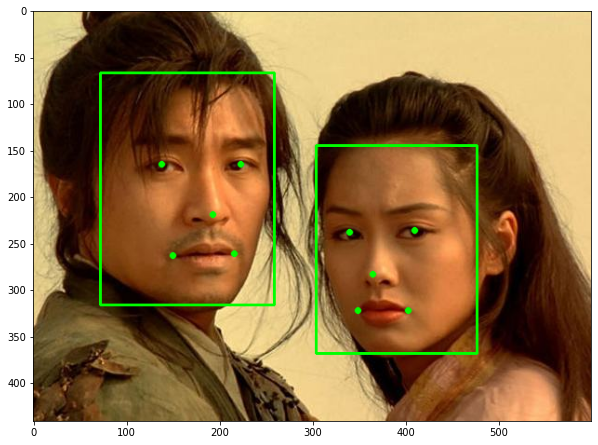

In [23]:
%%time
image = cv2.imread("dhxy.jpg")
objs = mtcnn.detect(image, 150, 300)
for obj in mtcnn.oobjs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(image, (bx, by), (br, bb), (0, 255, 0), 2)
    
    for x, y in obj.landmarks:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1, 16)
    
plt.figure(figsize=(10, 10))
plt.imshow(image[...,::-1])

CPU times: user 30 s, sys: 3.09 s, total: 33.1 s
Wall time: 13.8 s


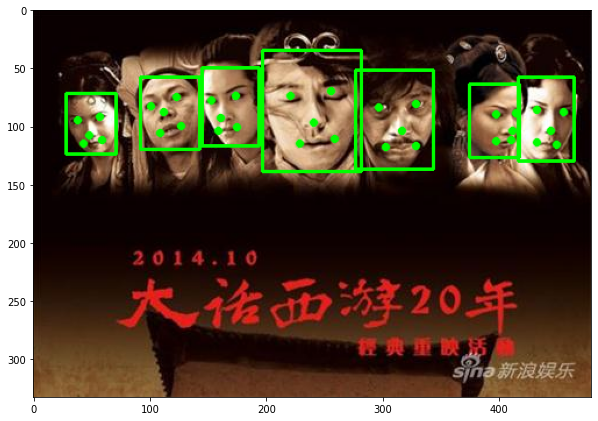

In [24]:
%%time
image = cv2.imread("dhxy_jz.jpg")
objs = mtcnn.detect(image, 50, 120)
for obj in mtcnn.oobjs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(image, (bx, by), (br, bb), (0, 255, 0), 2)
    
    for x, y in obj.landmarks:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1, 16)
    
plt.figure(figsize=(10, 10))
plt.imshow(image[...,::-1])

CPU times: user 19.1 s, sys: 1.85 s, total: 21 s
Wall time: 9.05 s


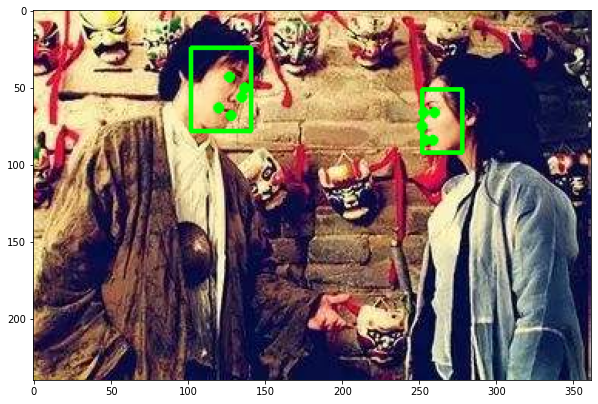

In [25]:
%%time
image = cv2.imread("zy.jpg")
objs = mtcnn.detect(image, 30, 70)
for obj in mtcnn.oobjs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(image, (bx, by), (br, bb), (0, 255, 0), 2)
    
    for x, y in obj.landmarks:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1, 16)
    
plt.figure(figsize=(10, 10))
plt.imshow(image[...,::-1])

In [12]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

while True:
    ok, frame = cap.read()
    if not ok:
        continue
    
    objs = mtcnn.detect(frame, 150, 250)
    for obj in objs:
        bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
        cv2.rectangle(frame, (bx, by), (br, bb), (0, 255, 0), 2)
        
        for x, y in obj.landmarks:
            cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 0), -1, 16)
    
    cv2.imshow("video", frame)
    if cv2.waitKey(1) == ord('q'):
        break
    
    ok, frame = cap.read()
cap.release()

### 1.BP，具有抽象各种layer能力的实现方式，不包括Conv，但是得包括Dropout，BatchNorm
### 2.MTCNN，完整的复现，具有layer封装抽象能力的实现方式